In [25]:
%load_ext autoreload
%autoreload 2

import os 
import torch
import torch.nn as nn
import numpy as np
import pickle 
import tqdm

from data_generators import batches_generator, transaction_features
from models import TransactionsRnn

In [37]:
import seaborn as sns
import tqdm
from matplotlib import pyplot as plt

%matplotlib inline

sns.set(style='whitegrid')
import matplotlib
matplotlib.rcParams["figure.dpi"] = 300
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'

In [3]:
with open('./assets/embedding_projections.pkl', 'rb') as f:
    embedding_projections = pickle.load(f)

In [6]:
path_to_dataset = '../train_buckets'
dir_with_datasets = os.listdir(path_to_dataset)
dataset_train = sorted([os.path.join(path_to_dataset, x) for x in dir_with_datasets])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
ckpt = torch.load('/datasets/home/andrey/al/romashka/wandb/run-20221101_224414-1hiz5uxa/checkpoints/epoch_9.ckpt')
model = TransactionsRnn(transaction_features, embedding_projections)
model.load_state_dict(ckpt)
model.to(device);

In [68]:
train_generator = batches_generator(dataset_train, batch_size=128, shuffle=True,
                                    device=device, is_train=True, output_format='torch')

In [ ]:
losses = []
lengths = []
targets = []
preds = []


loss_function = nn.BCEWithLogitsLoss(reduction='none', )      
        
with torch.no_grad():
    model.eval()
    for batch in tqdm.tqdm(train_generator, position=0, leave=True):

        output = torch.flatten(model(batch['transactions_features'], batch['product']))
        batch_loss = loss_function(output, batch['label'].float()).cpu()

        targets.extend(batch['label'].cpu().flatten())
        preds.extend(output.detach().cpu().flatten())

        length_tmp = torch.sum(batch['transactions_features'][0] != 0, axis=1).cpu()

        losses.append(batch_loss)
        lengths.append(length_tmp)

In [78]:
np_len = torch.cat(lengths).numpy()
np_losses = torch.cat(losses).numpy()
np_preds = torch.stack(preds).numpy()
np_targets = torch.stack(targets).numpy()

In [79]:
indices = np.random.choice(np.arange(len(np_len)), size=10000)

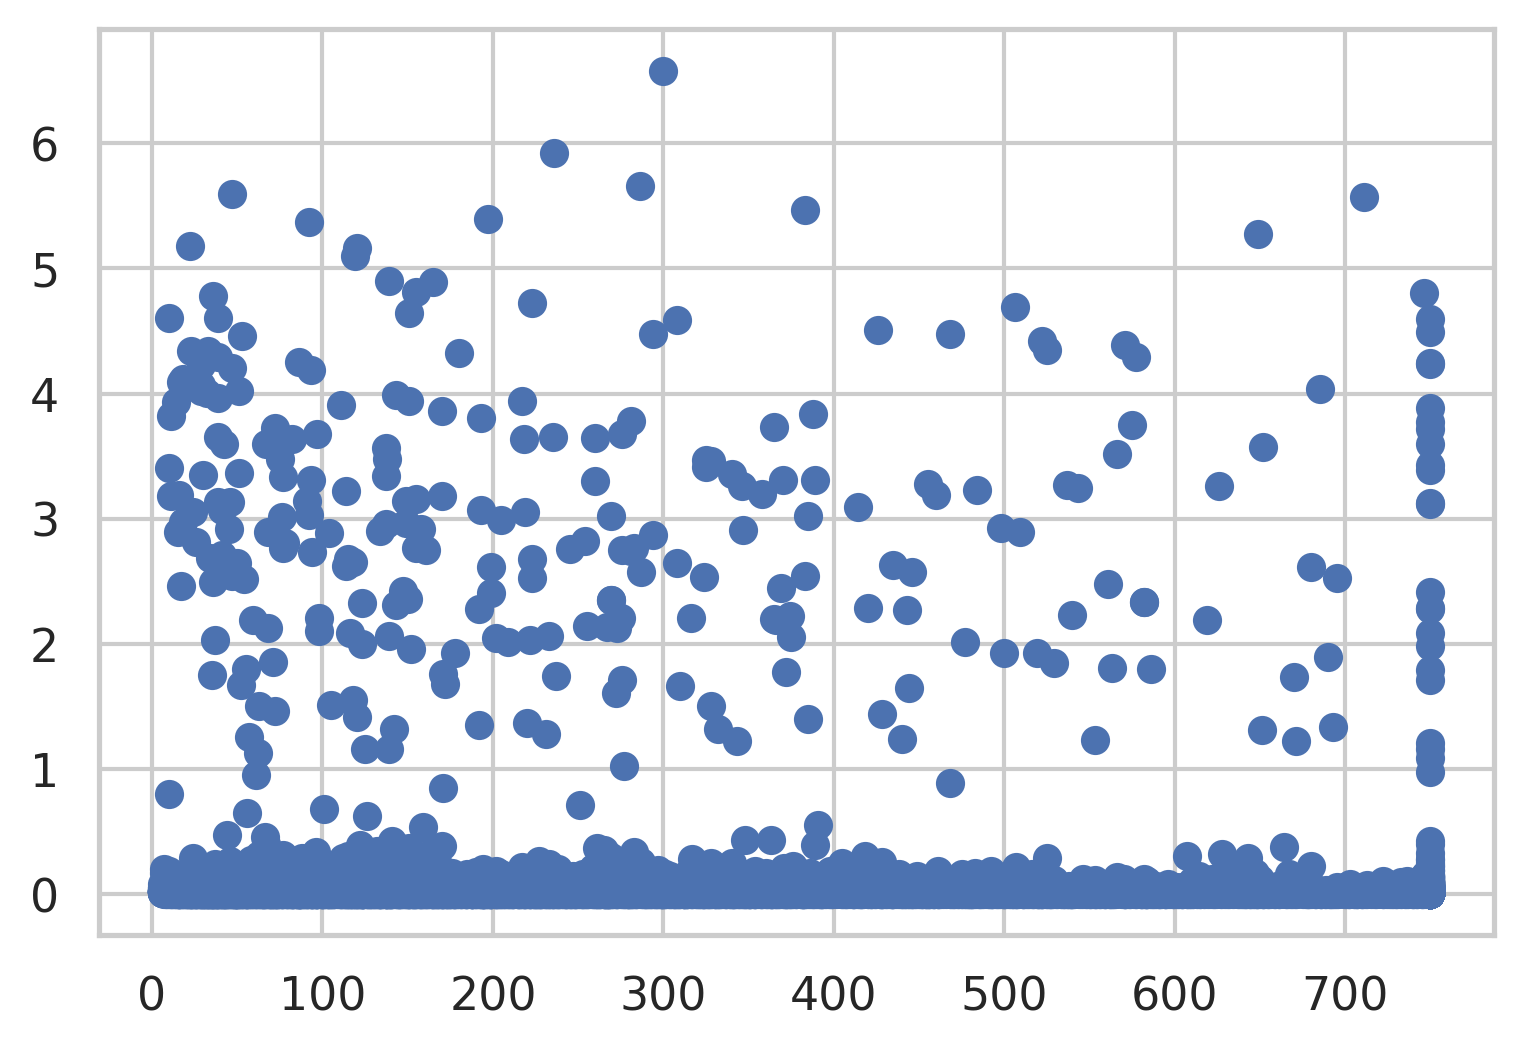

In [80]:
plt.scatter(np_len[indices], np_losses[indices])

In [30]:
# sys.path.append('/datasets/home/andrey/al/AlfaBattle2.0/rnn_baseline')

In [ ]:
    val_generator = batches_generator(dataset_val, batch_size=batch_size, shuffle=False,
                                      device=device, is_train=True, output_format='torch')
    model.eval()

    for batch in tqdm(val_generator, desc='Evaluating model'):
        targets.extend(batch['label'].detach().cpu().numpy().flatten())
        output = model(batch['transactions_features'], batch['prod